In [35]:
import os, time, copy
import sys
sys.path.insert(1, '../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.stats import norm, binom
from ppi import linfty_dkw, linfty_binom, wsr_iid, binomial_iid
import pdb

## Load in and pre-process data

In [8]:
# Get data 2006-2014 from the following link: https://darchive.mblwhoilibrary.org/handle/1912/7341
# Unzip and merge the datasets in the following directory
calib_data = np.load('calib-outputs.npz')
test_data = np.load('test-outputs.npz')
calib_preds = calib_data['preds'].astype(int)
calib_labels = calib_data['labels'].astype(int)
test_preds = test_data['preds'].astype(int)
test_labels = test_data['labels'].astype(int)
classes = np.load('classes.npy')
num_classes = classes.shape[0]

plankton_classes = np.isin(classes,['mix','mix_elongated','detritus','bad', 'bead', 'bubble', 'other_interaction', 'pollen', 'spore'],invert=True)
plankton_classes_list = np.array(np.where(plankton_classes)[0])

true_count = np.isin(test_labels, plankton_classes_list).sum()
N = test_labels.shape[0]
true_frac = true_count/N
uncorrected_est = np.isin(test_preds, plankton_classes_list).sum()

calib_preds = np.isin(calib_preds, plankton_classes_list)
calib_labels = np.isin(calib_labels, plankton_classes_list)
test_preds = np.isin(test_preds, plankton_classes_list)
test_labels = np.isin(test_labels, plankton_classes_list)

# Count number of each unique class
calib_uq, calib_uq_counts = np.unique(calib_labels, return_counts=True)
calib_uq_freq = calib_uq_counts/calib_uq_counts.sum()
calib_uq_sort = np.argsort(calib_uq_freq)[::-1]
calib_uq_freq = calib_uq_freq[calib_uq_sort]; calib_uq = calib_uq[calib_uq_sort];
calib_uq_cumsum = np.cumsum(calib_uq_freq)

print(f"Calib acc: {(calib_preds == calib_labels).astype(int).mean()}")
print(f"Test acc: {(test_preds == test_labels).astype(int).mean()}")

Calib acc: 0.962313466496375
Test acc: 0.9789407941012395


In [9]:
# Problem setup
alpha = 0.05 # Total budget
delta = 0.048 # Rectifier budget
K = 2
nu = np.array([0,1])
n_max = calib_preds.shape[0]
ns = np.linspace(1000, n_max, 20).astype(int)
num_trials = 50

## Interval constructions

In [10]:
def form_qfhat(test_preds):
    # Construct the point estimate
    target_uq, target_uq_counts = np.unique(test_preds, return_counts=True)
    target_uq_freq = target_uq_counts/target_uq_counts.sum()
    target_uq_sort = np.argsort(target_uq_freq)[::-1]
    target_uq_freq = target_uq_freq[target_uq_sort]; target_uq = target_uq[target_uq_sort];
    qfhat = target_uq_freq
    return qfhat

In [11]:
def imputed(test_preds, alpha, delta):
    N = test_preds.shape[0]
    grid = np.linspace(0.01,0.99,1000)
    qfhat = form_qfhat(test_preds)
    naive_freq_interval = binomial_iid(N,delta,qfhat[1])
    naive_count_lb = int(binom.ppf((alpha-delta)/2, N, naive_freq_interval[0]))
    naive_count_ub = int(binom.ppf(1-(alpha-delta)/2, N, naive_freq_interval[1]))
    return [naive_count_lb, naive_count_ub]

In [12]:
def ppi_iid(calib_preds, test_preds, calib_labels, alpha, delta):
    N = test_preds.shape[0]
    qfhat = form_qfhat(test_preds)

    bias_estimate = (calib_preds.astype(float) - calib_labels.astype(float)).mean()
    grid = np.linspace(0.45,0.55,1000)
    possible_biases = bias_estimate + 2*wsr_iid((calib_preds.astype(float) - calib_labels.astype(float)+1)/2, delta, grid, intersection=False)-1
    naive_freq_interval = binomial_iid(N,(alpha-delta)/2,qfhat[1])
    iid_lb = naive_freq_interval[0]+ possible_biases.min()
    iid_ub = naive_freq_interval[1] + possible_biases.max()
    iid_count_lb = int(binom.ppf((alpha-delta)/4, N, iid_lb))
    iid_count_ub = int(binom.ppf(1-(alpha-delta)/4, N, iid_ub))
    return [iid_count_lb, iid_count_ub]

In [13]:
def ppi_label_shift(calib_preds, test_preds, calib_labels, K, alpha, delta):
    # Construct the confusion matrix
    n = calib_preds.shape[0]
    N = test_preds.shape[0]

    # Construct column-normalized confusion matrix Ahat
    C = np.zeros((K,K)).astype(int)
    for j in range(K):
        for l in range(K):
            C[j,l] = np.bitwise_and(calib_preds == j,calib_labels == l).astype(int).sum()
    Ahat = C / C.sum(axis=0)
    # Invert Ahat
    Ahatinv = np.linalg.inv(Ahat)
    qfhat = form_qfhat(test_preds)
    # Calculate the bound
    point_estimate = nu@Ahatinv@qfhat

    nmin = C.sum(axis=0).min()

    def invert_theta(theta): return np.sqrt(1/(4*nmin))*(norm.ppf(1-(theta*delta)/(2*K**2)) - norm.ppf((theta*delta)/(2*K**2))) - np.sqrt(2/N*np.log(2/((1-theta)*delta)))
    try:
        theta = brentq(invert_theta,1e-9,1-1e-9)
    except:
        theta = 0.999
    epsilon1 = max([linfty_binom(C.sum(axis=0)[k], K, theta*delta, Ahat[:,k]) for k in range(K)])
    epsilon2 = linfty_dkw(N,K,(1-theta)*delta)

    qyhat_lb = np.clip(point_estimate - epsilon1 - epsilon2, 0, 1)
    qyhat_ub = np.clip(point_estimate + epsilon1 + epsilon2, 0, 1)

    count_plankton_lb = int(binom.ppf((alpha-delta)/2, N, qyhat_lb))
    count_plankton_ub = int(binom.ppf(1-(alpha-delta)/2, N, qyhat_ub))
    return [count_plankton_lb, count_plankton_ub]

## Perform Monte-Carlo experiment to see width of intervals

In [37]:
columns = ["lb","ub","covered","estimator","n"]
import warnings

#suppress warnings
warnings.filterwarnings('ignore') # Filter RuntimeWarninggs about exp overflow.

results = []
for j in tqdm(range(ns.shape[0])):
    for i in range(num_trials):
        n = ns[j]
        randidx = np.random.permutation(n_max)
        _calib_preds = calib_preds[randidx[:n]]
        _calib_labels = calib_labels[randidx[:n]]
        # Without label shift
        _ppi_iid = ppi_iid(_calib_preds, test_preds, _calib_labels, alpha, delta)
        # With label shift
        _ppi_ls = ppi_label_shift(_calib_preds, test_preds, _calib_labels, K, alpha, delta)
        temp_df = pd.DataFrame(np.zeros((2,len(columns))), columns=columns)
        temp_df.loc[0] = _ppi_iid[0], _ppi_iid[1], (_ppi_iid[0] <= true_count) & (true_count <= _ppi_iid[1]), "prediction-powered (i.i.d.)", n
        temp_df.loc[1] = _ppi_ls[0], _ppi_ls[1], (_ppi_ls[0] <= true_count) & (true_count <= _ppi_ls[1]), "prediction-powered (label shift)", n
        results += [temp_df]
# Naive
_ii = imputed(test_preds, alpha, delta)
temp_df = pd.DataFrame(np.zeros((1,len(columns))), columns=columns)
temp_df.loc[0] = _ii[0], _ii[1], (_ii[0] <= true_count) & (true_count <= _ii[1]), "naive", n_max
results += [temp_df]

df = pd.concat(results)
df["width"] = df["ub"] - df["lb"]

os.makedirs('./.cache', exist_ok=True)
df.to_pickle('./.cache/plankton-results.pkl')

  0%|                                                                                                           | 0/20 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Plotting

In [84]:
def make_plots(df, true, num_intervals):
    # Line plots
    ns = np.sort(np.unique(df["n"]))

    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(9,3))
    sns.set_theme(style="white", font_scale=1, font="DejaVu Sans")

    make_lineplots(df, axs[2])

    make_intervals(df, true, axs[1], num_intervals)
    
    axs[0].set_axis_off()
    plt.tight_layout()
    
    os.makedirs('./plankton-results/', exist_ok=True)
    plt.savefig('./plankton-results/results.pdf', bbox_inches='tight')

def make_lineplots(df, ax):
    plot_df = df[["estimator","width", "n"]].groupby(["estimator","n"], group_keys=False).mean()["width"].reset_index()
    lplt = sns.lineplot(data=plot_df[plot_df["estimator"] != "naive"], x="n", y="width", hue="estimator", ax=ax, hue_order=["prediction-powered (label shift)", "prediction-powered (i.i.d.)"], palette=["#71D26F", "#BFB9B9", "#FFCD82"])
    ci_naive = df[df["estimator"] == "naive"]
    ax.axhline(ci_naive["width"].mean(), xmin=0.0, xmax=n_max, label="naive", color="#FFCD82")
    ax.set_ylabel("width (#)")
    ax.set_xlabel("n")
    ax.xaxis.set_tick_params()
    ax.yaxis.set_tick_params()
    ax.locator_params(tight=True, nbins=4)
    lplt.get_legend().remove()
    sns.despine(ax=ax,top=True,right=True)

def make_intervals(df, true, ax, num_intervals):
    sns.despine(ax=ax,top=True,right=True,left=True)
    ns = np.unique(df['n']).astype(int)
    n_idx = 8
    num_trials = (len(df)-1)//(2*ns.shape[0])
    linewidth = 5
    linewidth_modifier = 1.1
    offset = 0.25
    ylim = [0,1.15]
    xlim = [None, None]
    
    pp_intervals = []
    classical_intervals = []
    
    lower_endpoints = np.stack(
        [
            np.stack([df.lb[(df.estimator == "prediction-powered (label shift)") & (df.n == n)] for n in ns], axis=0),
            np.stack([df.lb[(df.estimator == "prediction-powered (i.i.d.)") & (df.n == n)] for n in ns], axis=0),
        ],
        axis=2
    )

    upper_endpoints = np.stack(
        [
            np.stack([df.ub[(df.estimator == "prediction-powered (label shift)") & (df.n == n)] for n in ns], axis=0),
            np.stack([df.ub[(df.estimator == "prediction-powered (i.i.d.)") & (df.n == n)] for n in ns], axis=0),
        ],
        axis=2
    )
    
    imputed_interval = [df.lb[(df.estimator == "naive")].item(), df.ub[(df.estimator == "naive")].item()]
    
    for i in range(num_intervals):
        trial_idx = np.random.choice(num_trials)

        pp_intervals += [
            [lower_endpoints[n_idx,trial_idx,0], upper_endpoints[n_idx,trial_idx,0]]
        ]

        classical_intervals += [
            [lower_endpoints[n_idx,trial_idx,1], upper_endpoints[n_idx,trial_idx,1]]
        ]

    ax.axvline(true, ymin=0.0, ymax=1, linestyle="dotted", linewidth=3, label="true deforestation fraction", color="#F7AE7C")

    for i in reversed(range(num_intervals)):
        pp_interval = pp_intervals[i]
        classical_interval = classical_intervals[i]

        if i == 0:
            ax.plot([pp_interval[0], pp_interval[1]],[0.7, 0.7], linewidth=linewidth, color="#DAF3DA", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#71D26F"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#71D26F"), pe.Normal()], label=' prediction-powered (label shift)', solid_capstyle="butt")
            ax.plot([classical_interval[0], classical_interval[1]],[0.25,0.25], linewidth=linewidth, color="#EEEDED", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#BFB9B9"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#BFB9B9"), pe.Normal()], label=' prediction-powered (i.i.d.)', solid_capstyle="butt")
            ax.plot([imputed_interval[0], imputed_interval[1]],[0.1, 0.1], linewidth=linewidth, color="#FFEACC", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#FFCD82"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#FFCD82"), pe.Normal()], label=' imputed', solid_capstyle="butt")
        else:
            lighten_factor = 0.8/np.sqrt(i)
            yshift = i*0.07
            ax.plot([pp_interval[0], pp_interval[1]],[0.7 + yshift, 0.7 + yshift], linewidth=linewidth, color=lighten_color("#DAF3DA", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Normal()], solid_capstyle="butt")
            ax.plot([classical_interval[0], classical_interval[1]],[0.25 + yshift,0.25 + yshift], linewidth=linewidth, color=lighten_color("#EEEDED", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Normal()], solid_capstyle="butt")


    ax.set_xlabel("# plankton", labelpad=10)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


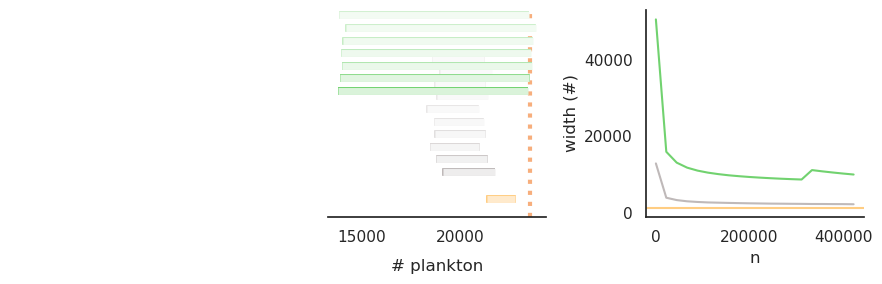

In [85]:
df = pd.read_pickle('./.cache/plankton-results.pkl')
num_intervals = 10
make_plots(df, true_count, num_intervals)